In [33]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

from itertools import product
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from torch.nn import Conv2d
from torch.nn import CrossEntropyLoss
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Sequential
from torch.nn import Softmax
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [39]:
# Path to save visuals
OUT_PATH = '/home/sbaldasty/Code/github/sbaldasty/bitflippin.com/static/article/adversarial-example'

# Pretrained model path
MODEL_PATH = './9920.pth.tar'

# Path for dataset caching
DATA_PATH = './data'

# Number of sample images to study
N_SAMPLES = 6

# Random seed
SEED = 8

# How big the digit images are
THUMBNAIL_SIZE = (1, 1)

# How big the line charts are
SERIES_SIZE = (3, 2)

# How big the heatmaps are
HEATMAP_SIZE = (4, 3)

In [3]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

## Sample images

Retrieve sample images from MNIST.

In [4]:
mnist = MNIST(
    root=DATA_PATH,
    train=True,
    download=True,
    transform=ToTensor())

loader = DataLoader(
    dataset=mnist,
    batch_size=N_SAMPLES,
    shuffle=True)

images, labels = next(iter(loader))
labels = [label.item() for label in labels]

## Pre-trained model

Get a pretrained model for MNIST. Unbelievably there isn't one on the hub, so using one from the _adversarial-examples-pytorch_ repo.

In [5]:
model = Sequential(
    Conv2d(1, 32, kernel_size=3, padding=1),
    ReLU(),
    Conv2d(32, 32, kernel_size=3, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2),
    Conv2d(32, 64, kernel_size=3, padding=1),
    ReLU(),
    Conv2d(64, 64, kernel_size=3, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2),
    Flatten(),
    Linear(7 * 7 * 64, 200),
    ReLU(),
    Linear(200, 10),
    Softmax(dim=1))

Just load their saved parameters instead of doing a training loop. I converted the original model to use `Sequential` for presentation purposes on my website so now the keys don't match. That's what the hackery here is for.

In [6]:
saved = torch.load('9920.pth.tar', map_location='cpu')
matches = zip(model.state_dict().items(), saved['state_dict'].items())
states = { k1: v2 for (k1, v1), (k2, v2) in matches }
model.load_state_dict(states)
model.eval()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=3136, out_features=200, bias=True)
  (12): ReLU()
  (13): Linear(in_features=200, out_features=10, bias=True)
  (14): Softmax(dim=1)
)

Plot the images, their true labels, and the model predictions, just to show we have them all.

In [7]:
def calculate_confidence(image):
    unsqueezed_image = image.unsqueeze(0)
    output = model(unsqueezed_image)
    arrays = output.detach().numpy()
    return output, arrays[0]

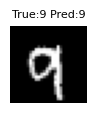

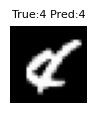

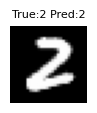

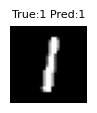

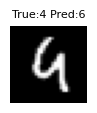

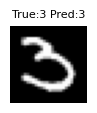

In [8]:
for i in range(N_SAMPLES):
    output, confidence = calculate_confidence(images[i])
    prediction = np.argmax(confidence)
    plt.figure(figsize=THUMBNAIL_SIZE)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.axis('off')

    plt.title(
        f'True:{labels[i]} Pred:{prediction}',
        fontsize=8)

    plt.savefig(
        f'{OUT_PATH}/baseline_{i}.png',
        transparent=True,
        bbox_inches='tight',
        pad_inches=0.1)

    plt.show()

## Untargeted attack

How to do the attack. Number of iterations is epsilon divided by alpha, so max perturbation will not exceed epsilon.

In [9]:
EPSILON = 0.07
ALPHA = .006

iterations = int(EPSILON / ALPHA)

In [10]:
def attack(image, label, epsilon, alpha, iterations):
    criterion = CrossEntropyLoss()
    orig = image
    image = image.clone().detach().requires_grad_(True)
    label = torch.tensor([label])
    confidences = []
    for _ in range(iterations):
        output, confidence = calculate_confidence(image)
        loss = criterion(output, label)
        loss.backward()
        perturbation = alpha * torch.sign(image.grad.data)

        perturbation = torch.clamp(
            image.data + perturbation - orig,
            min=-epsilon,
            max=epsilon)

        image.data = orig + perturbation
        image.grad.data.zero_()
        confidences.append(confidence)

    image = image.detach().squeeze()
    return image, confidences, np.argmax(confidence)

Demonstrate misclassifications using the attack.

In [11]:
perturbed = []
confidences = []
predictions = []

for i in range(N_SAMPLES):
    output, confidence, prediction = attack(
        images[i], labels[i], EPSILON, ALPHA, iterations)

    perturbed.append(output)
    confidences.append(confidence)
    predictions.append(prediction)

/home/sbaldasty/.pyenv/versions/3.13.2/envs/adversarial-ai/lib/python3.13/site-packages/torch/autograd/graph.py:823: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Show the perturbed images and their true / predicted classes.

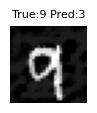

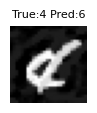

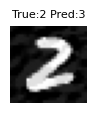

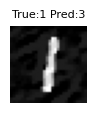

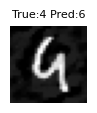

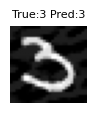

In [12]:
for i in range(N_SAMPLES):
    plt.figure(figsize=THUMBNAIL_SIZE)
    plt.axis('off')
    plt.imshow(perturbed[i], cmap='gray')

    plt.title(
        f'True:{labels[i]} Pred:{predictions[i]}',
        fontsize=8)

    plt.savefig(
        f'{OUT_PATH}/untargeted_{i}.png',
        transparent=True,
        bbox_inches='tight',
        pad_inches=0.1)

    plt.show()

Show the trajectories of the confidence vectors over the iterations.

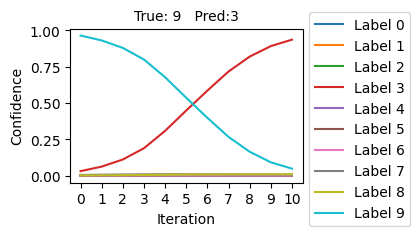

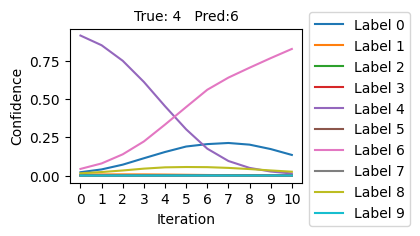

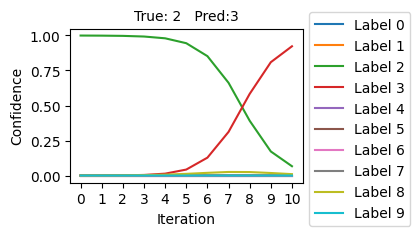

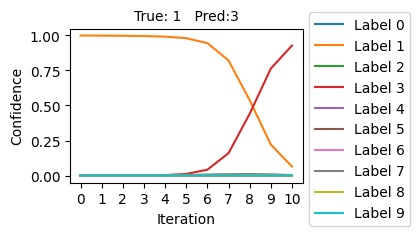

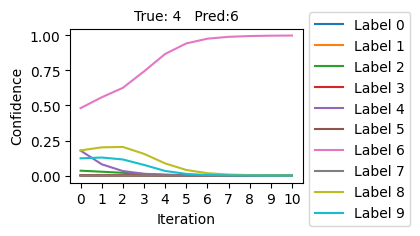

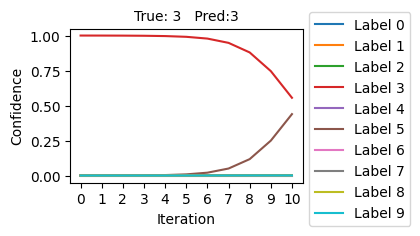

In [ ]:
for i in range(N_SAMPLES):
    plt.figure(figsize=SERIES_SIZE)

    plt.title(
        f'True: {labels[i]}   Pred:{predictions[i]}',
        fontsize=10)

    plt.xlabel('Iteration')
    plt.ylabel('Confidence')
    plt.xticks(list(range(iterations)))

    for j in range(10):
        cfs = [confidences[i][k][j] for k in range(iterations)]
        plt.plot(list(range(len(cfs))), cfs, label=f'Label {j}')

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1.15))

    plt.savefig(
        f'{OUT_PATH}/series_{i}.png',
        bbox_inches='tight',
        pad_inches=0.1,
        transparent=True)
    
    plt.show()

Generate heatmaps for the one of the examples for ranges of values for epsilon and alpha. The _heat_ is the model's confidence that the example's true label is the correct one.

In [ ]:
epsilons = np.arange(0.0001, 0.1501, 0.0025)
alphas = np.arange(0.0001, 0.1501, 0.0025)

output = np.full(
    (N_SAMPLES, len(epsilons), len(alphas)),
    np.nan)

grid = product(
    enumerate(zip(images, labels)),
    enumerate(epsilons),
    enumerate(alphas))

for (k, (image, label)), (i, e), (j, a) in grid:
    if a > e: continue
    its = int(e / a) + 1
    _, cv, _ = attack(image, label, e, a, its)
    output[k][i][j] = cv[-1][label]

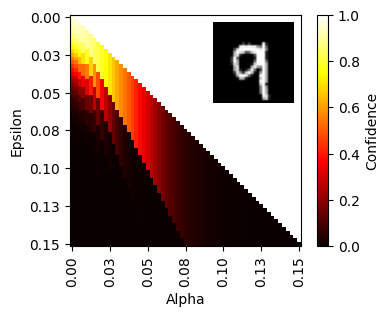

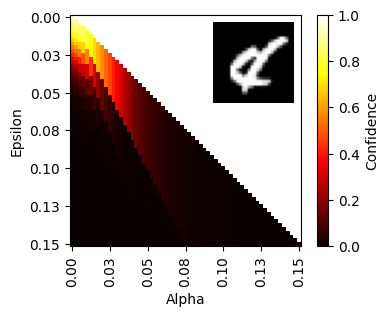

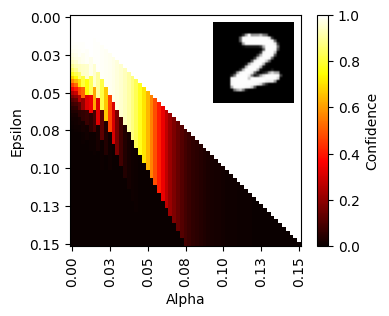

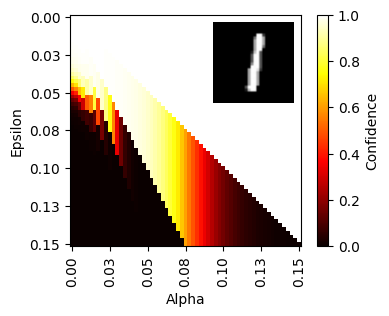

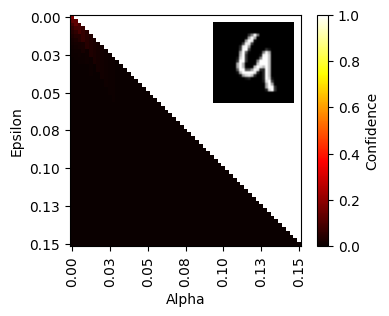

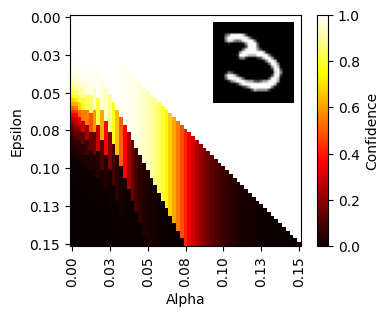

In [ ]:
INTERVAL = 10

def ticks(lst):
    return np.arange(0, len(lst), INTERVAL)

def tick_labels(lst):
    return [f'{lst[x]:.2f}' for x in range(0, len(lst), INTERVAL)]

for i in range(N_SAMPLES):
    plt.figure(figsize=HEATMAP_SIZE)
    plt.imshow(output[i], cmap='hot', interpolation='nearest')
    plt.colorbar().set_label('Confidence')
    plt.clim(0.0, 1.0)
    plt.xlabel('Alpha')
    plt.ylabel('Epsilon')

    plt.xticks(
        ticks=ticks(alphas),
        labels=tick_labels(alphas),
        rotation=90)

    plt.yticks(
        ticks=ticks(epsilons),
        labels=tick_labels(epsilons))

    inset_ax = inset_axes(
        parent_axes=plt.gca(),
        width='35%',
        height='35%',
        loc='upper right')

    inset_ax.imshow(images[i].squeeze(), cmap='gray')
    inset_ax.axis('off')

    plt.savefig(
        f'{OUT_PATH}/heatmap_{i}.png',
        bbox_inches='tight',
        pad_inches=0.1,
        transparent=True)

    plt.show()